# Imports

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from scipy.stats import norm
import sys
import pandas as pd
import pickle
import seaborn as sns

## Helper Functions

In [85]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import covariance as c
import visualization as viz

# Set Directory Paths

In [86]:
# Directory path to load formatted gfap_ferritin_dataDir Data
%store -r gfap_ferritin_dataDir

# Directory path to save Calcualted Analysis Data
%store -r gfap_ferritin_CalData

# Load Formatted TAU, TDP43 - GFAP, Ferritin Data

In [87]:
# GFAP_TAU
with open(os.path.join(gfap_ferritin_dataDir, 'GFAP_TAU.pkl'), 'rb') as f:
    GFAP_TAU = pickle.load(f)
f.close()

# Ferr_TAU
with open(os.path.join(gfap_ferritin_dataDir, 'Ferr_TAU.pkl'), 'rb') as f:
    Ferr_TAU = pickle.load(f)
f.close()

# GFAP_TDP
with open(os.path.join(gfap_ferritin_dataDir, 'GFAP_TDP.pkl'), 'rb') as f:
    GFAP_TDP = pickle.load(f)
f.close()

# Ferr_TDP
with open(os.path.join(gfap_ferritin_dataDir, 'Ferr_TDP.pkl'), 'rb') as f:
    Ferr_TDP = pickle.load(f)
f.close()

In [88]:
# Load Label Names
# LabelNames
with open(os.path.join(gfap_ferritin_dataDir, 'LabelNames.pkl'), 'rb') as f:
    LabelNames = pickle.load(f)
f.close()

# Data Distribution

In [89]:
def dist_boxplot(data, labels, min_val, max_val, title, x_label, y_label):
    # Reorder the data and labels (group by regions L, R)
    new_order = [i//2 if i % 2 == 0 else (i//2) + 20 for i in range(40)]
    reordered_data = data[:, new_order]
    reordered_labels = [labels[i] for i in new_order]
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create boxplots for each column
    boxplot = sns.boxplot(data=reordered_data, width=0.5, ax=ax, fliersize=0, boxprops=dict(alpha=.3))

    # Add individual data points with aligned x-values
    for i, col_data in enumerate(reordered_data.T):
        # Handle NaNs
        col_data = col_data[~np.isnan(col_data)]

        jitter = np.random.normal(0, 0.1, size=len(col_data))  # Add jitter for better visualization
        x = np.full_like(col_data, i) + jitter
        ax.scatter(x, col_data, alpha=0.5, color='blue', s=5)

     # Add vertical lines every two columns
    for i in range(1, 38, 2):
        ax.axvline(x=i + 0.5, color='grey', linestyle='--', lw=0.5)
        
    # Set x-axis labels
    ax.set_xticks(np.arange(0, 40))
    ax.set_xticklabels(reordered_labels, rotation=45, ha='right')  # Use NeuN_Labels as x-axis labels

    # Set y-axis limits (replace these values with your desired limits)
    y_min_limit = min_val  # Minimum limit
    y_max_limit = max_val  # Maximum limit
    ax.set_ylim(y_min_limit, y_max_limit)

    # Set plot title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [90]:
# min max
all_values = np.concatenate([GFAP_TAU.flatten(), Ferr_TAU.flatten(), GFAP_TDP.flatten(), Ferr_TDP.flatten()])
min_val = np.nanmin(all_values)
max_val = np.nanmax(all_values)
buffer = (max_val-min_val) * 0.1

min_val = min_val - buffer
max_val = max_val + buffer

## TAU - GFAP

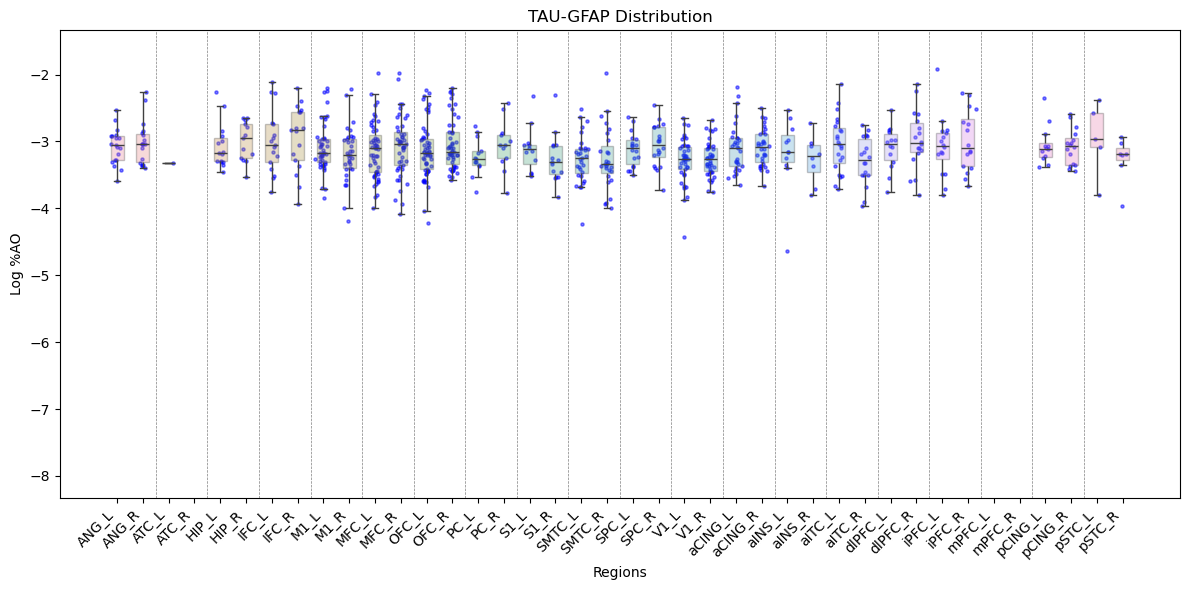

In [91]:
dist_boxplot(GFAP_TAU, LabelNames, min_val, max_val, 'TAU-GFAP Distribution', 'Regions', 'Log %AO')

## TAU - Ferritin

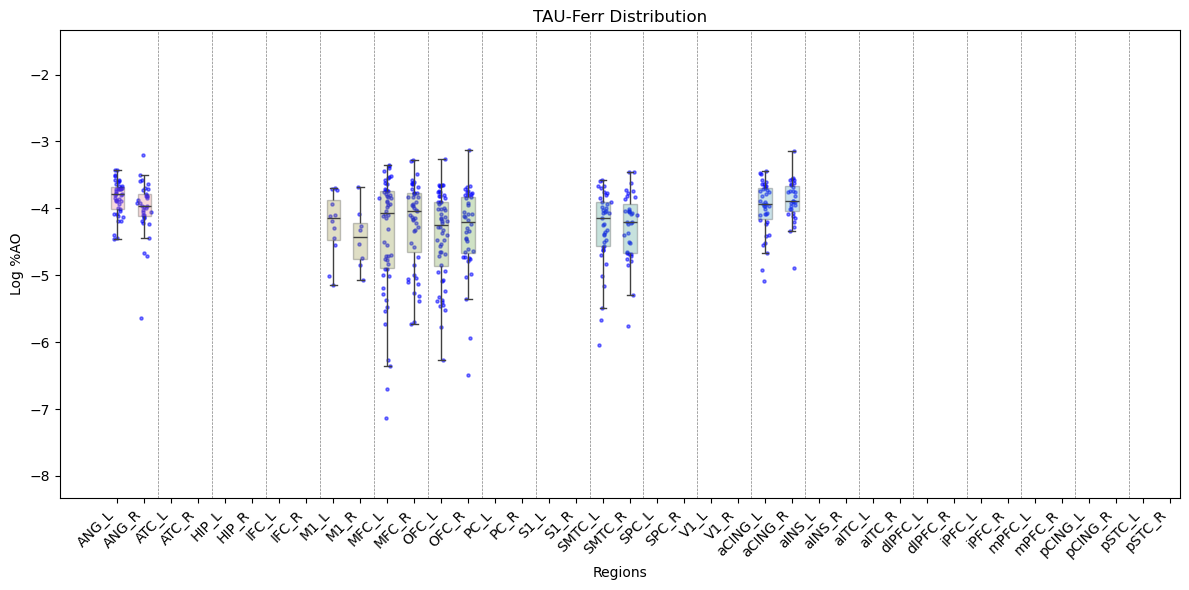

In [92]:
dist_boxplot(Ferr_TAU, LabelNames, min_val, max_val, 'TAU-Ferr Distribution', 'Regions', 'Log %AO')

## TDP - GFAP

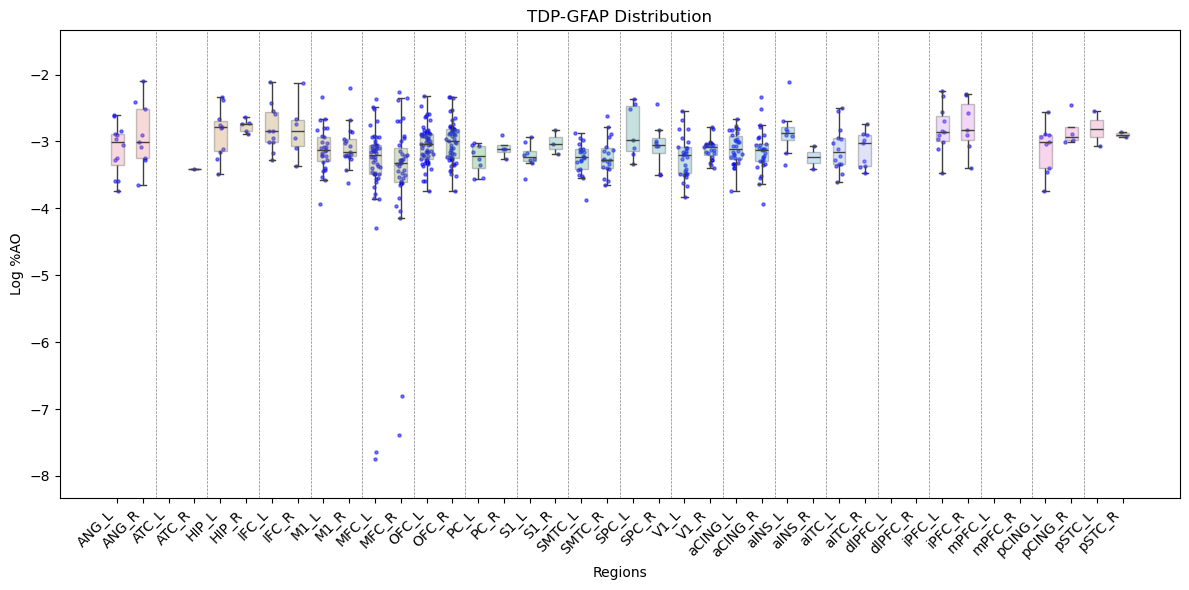

In [93]:
dist_boxplot(GFAP_TDP, LabelNames, min_val, max_val, 'TDP-GFAP Distribution', 'Regions', 'Log %AO')

## TDP - Ferritin

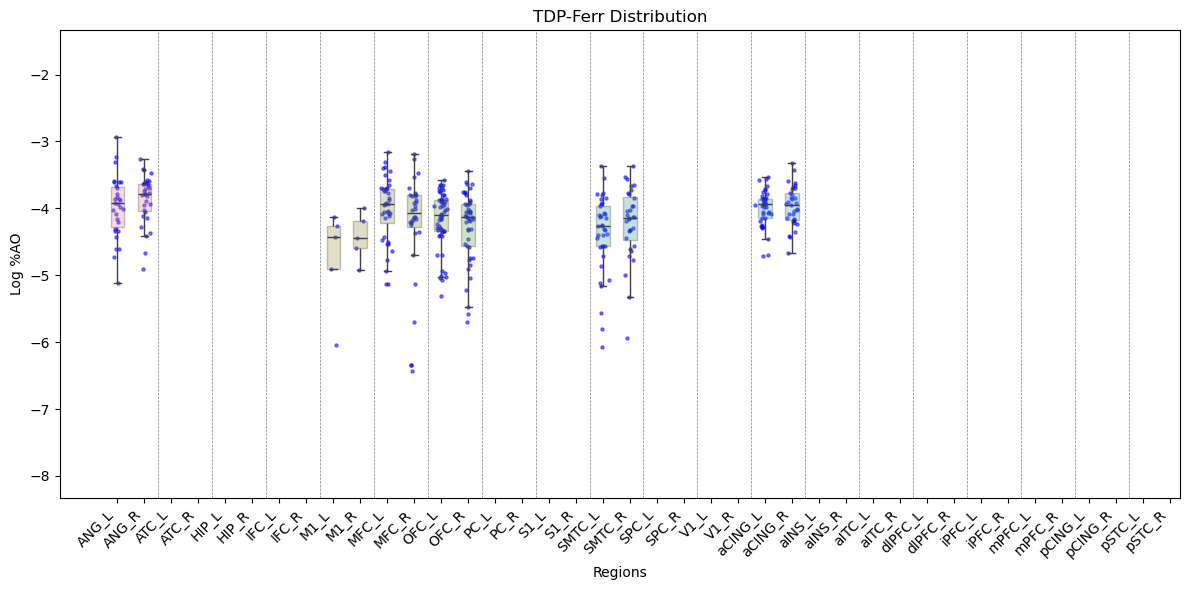

In [94]:
dist_boxplot(Ferr_TDP, LabelNames, min_val, max_val, 'TDP-Ferr Distribution', 'Regions', 'Log %AO')

# Parameter/Variable Setting

## P-value Threshold List

In [95]:
# pthresh_list = [0.05]
pthresh = 0.05

## Covariance Matrix Threshold (to remove noise)

In [96]:
cov_thresh = 0.1

## LabelNames we are able to map to 3D. In alphabetical order (_L first and then _R)

In [97]:
LabelNames

Index(['ANG_L', 'ATC_L', 'HIP_L', 'IFC_L', 'M1_L', 'MFC_L', 'OFC_L', 'PC_L',
       'S1_L', 'SMTC_L', 'SPC_L', 'V1_L', 'aCING_L', 'aINS_L', 'aITC_L',
       'dlPFC_L', 'iPFC_L', 'mPFC_L', 'pCING_L', 'pSTC_L', 'ANG_R', 'ATC_R',
       'HIP_R', 'IFC_R', 'M1_R', 'MFC_R', 'OFC_R', 'PC_R', 'S1_R', 'SMTC_R',
       'SPC_R', 'V1_R', 'aCING_R', 'aINS_R', 'aITC_R', 'dlPFC_R', 'iPFC_R',
       'mPFC_R', 'pCING_R', 'pSTC_R'],
      dtype='object', name='Region')

# Calculate Covariance Matrices

## TAU - GFAP

In [98]:
covGFAP_TAU = c.covCal(GFAP_TAU, GFAP_TAU, cov_thresh)

## TAU - Ferritin

In [99]:
covFerr_TAU = c.covCal(Ferr_TAU, Ferr_TAU, cov_thresh)

## TDP43 - GFAP

In [100]:
covGFAP_TDP = c.covCal(GFAP_TDP, GFAP_TDP, cov_thresh)

## TDP43 - Ferritin

In [101]:
covFerr_TDP = c.covCal(Ferr_TDP, Ferr_TDP, cov_thresh)

## 3. TAU > TDP and TDP > TAU (GFAP, Ferritin)

In [102]:
covGFAP_TAU_gt_TDP, covGFAP_TDP_gt_TAU = c.covCalSigXY(GFAP_TAU, GFAP_TDP, covGFAP_TAU, covGFAP_TDP, pthresh, cov_thresh)

In [103]:
covFerr_TAU_gt_TDP, covFerr_TDP_gt_TAU = c.covCalSigXY(Ferr_TAU, Ferr_TDP, covFerr_TAU, covFerr_TDP, pthresh, cov_thresh)

## 4. TAU > TDP and TDP > TAU RAW

In [104]:
covGFAP_TAU_gt_TDP_raw, covGFAP_TDP_gt_TAU_raw = c.covCalSigXYRaw(GFAP_TAU, GFAP_TDP, covGFAP_TAU, covGFAP_TDP, cov_thresh)

In [105]:
covFerr_TAU_gt_TDP_raw, covFerr_TDP_gt_TAU_raw = c.covCalSigXYRaw(Ferr_TAU, Ferr_TDP, covFerr_TAU, covFerr_TDP, cov_thresh)

# Saving

In [106]:
# covGFAP_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU, f)
f.close()
# covFerr_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP, f)
f.close()
# covFerr_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TAU_gt_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU_gt_TDP.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU_gt_TDP, f)
f.close()
# covGFAP_TDP_gt_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP_gt_TAU.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP_gt_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covFerr_TAU_gt_TDP
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU_gt_TDP.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU_gt_TDP, f)
f.close()
# covFerr_TDP_gt_TAU
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP_gt_TAU.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP_gt_TAU, f)
f.close()
#----------------------------------------------------------------------------
# covGFAP_TAU_gt_TDP_raw
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TAU_gt_TDP_raw.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TAU_gt_TDP_raw, f)
f.close()
# covGFAP_TDP_gt_TAU_raw
with open(os.path.join(gfap_ferritin_CalData, 'covGFAP_TDP_gt_TAU_raw.pkl'), 'wb') as f:
    pickle.dump(covGFAP_TDP_gt_TAU_raw, f)
f.close()
#----------------------------------------------------------------------------
# covFerr_TAU_gt_TDP_raw
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TAU_gt_TDP_raw.pkl'), 'wb') as f:
    pickle.dump(covFerr_TAU_gt_TDP_raw, f)
f.close()
# covFerr_TDP_gt_TAU_raw
with open(os.path.join(gfap_ferritin_CalData, 'covFerr_TDP_gt_TAU_raw.pkl'), 'wb') as f:
    pickle.dump(covFerr_TDP_gt_TAU_raw, f)
f.close()

In [107]:
print(np.count_nonzero(~np.isnan(covGFAP_TAU_gt_TDP_raw))/2)
print(np.count_nonzero(~np.isnan(covGFAP_TDP_gt_TAU_raw))/2)

126.0
126.0


In [108]:
print(np.count_nonzero(~np.isnan(covFerr_TAU_gt_TDP_raw))/2)
print(np.count_nonzero(~np.isnan(covFerr_TDP_gt_TAU_raw))/2)

26.0
26.0
